# End-to-End OCR 

## Recognition model

In [2]:
import re
import six
import math
import lmdb
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

from PIL import Image

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
import keras_ocr

BATCH_SIZE = 128
HOME_DIR = os.getenv('HOME')+'/aiffel/ocr'

TRAIN_DATA_PATH = HOME_DIR+'/MJ/MJ_train'
VALID_DATA_PATH = HOME_DIR+'/MJ/MJ_valid'
TEST_DATA_PATH = HOME_DIR+'/MJ/MJ_test'

print(TRAIN_DATA_PATH)

/home/aiffel-dj2/aiffel/ocr/MJ/MJ_train


In [3]:
path = os.path.join(os.getenv('HOME'),'aiffel/ocr/')
SAMPLE_IMG_PATH = path+'sample.jpg'

In [4]:
NUMBERS = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS
print(f"The total number of characters is {len(TARGET_CHARACTERS)}")

The total number of characters is 36


## Input Image 

original image width:72, height:31
target_img_size:(74, 32)
display img shape:(74, 32, 3)
label:Lube


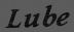

original image width:82, height:31
target_img_size:(84, 32)
display img shape:(84, 32, 3)
label:Spencerian


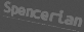

original image width:115, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:accommodatingly


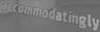

original image width:140, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:CARPENTER


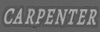

In [5]:
from IPython.display import display

env = lmdb.open(TRAIN_DATA_PATH, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
with env.begin(write=False) as txn:
    for index in range(1, 5):
        label_key = 'label-%09d'.encode() % index
        label = txn.get(label_key).decode('utf-8')
        img_key = 'image-%09d'.encode() % index
        imgbuf = txn.get(img_key)
        buf = six.BytesIO()
        buf.write(imgbuf)
        buf.seek(0)
        try:
            img = Image.open(buf).convert('RGB')

        except IOError:
            img = Image.new('RGB', (100, 32))
            label = '-'
        width, height = img.size
        print('original image width:{}, height:{}'.format(width, height))
        
        target_width = min(int(width*32/height), 100)
        target_img_size = (target_width,32 )
        
        print('target_img_size:{}'.format(target_img_size))
        
        img = np.array(img.resize(target_img_size)).transpose(1,0,2)
       
        print('display img shape:{}'.format(img.shape))
        print('label:{}'.format(label))
        display(Image.fromarray(img.transpose(1,0,2).astype(np.uint8)))

In [6]:
class MJDatasetSequence(Sequence):
    def __init__(self, 
                      dataset_path, # 데이터셋의 경로 
                      label_converter, # 아래에서 문자를 미리 정의된 index로 변환해 주는 converter로 직접 구현하도록 한다.
                      batch_size=1,
                      img_size=(100,32),
                      max_text_len=22,
                      is_train=False,
                      character=''
                ):
        
        self.label_converter = label_converter
        self.batch_size = batch_size
        self.img_size = img_size
        self.max_text_len = max_text_len
        self.character = character
        self.is_train = is_train
        self.divide_length = 100

        self.env = lmdb.open(dataset_path, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
        with self.env.begin(write=False) as txn:
            num_samples = int(txn.get('num-samples'.encode()))
            self.num_samples = int(num_samples)
            self.index_list = [index + 1 for index in range(self.num_samples)]
        
    def __len__(self):
        if self.is_train:
            return math.ceil(self.num_samples/self.batch_size/self.divide_length)
        return math.ceil(self.num_samples/self.batch_size/self.divide_length)
    
    # index에 해당하는 image와 label을 가져오는 메소드
    def _get_img_label(self, index):
        with self.env.begin(write=False) as txn:
            label_key = 'label-%09d'.encode() % index
            label = txn.get(label_key).decode('utf-8')
            img_key = 'image-%09d'.encode() % index
            imgbuf = txn.get(img_key)

            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)
            try:
                img = Image.open(buf).convert('RGB')

            except IOError:
                img = Image.new('RGB', self.img_size)
                label = '-'
            width, height = img.size
            
            target_width = min(int(width*self.img_size[1]/height), self.img_size[0])
            target_img_size = (target_width,self.img_size[1] )
            img = np.array(img.resize(target_img_size)).transpose(1,0,2)
            label = label.upper()[:self.max_text_len]
            out_of_char = f'[^{self.character}]'
            label = re.sub(out_of_char, '', label)

        return (img, label)
    
    # idx번째 배치를 가져오는 메소드
    def __getitem__(self, idx):
        batch_indicies = self.index_list[
            idx*self.batch_size:
            (idx+1)*self.batch_size
        ]
        input_images = np.zeros([self.batch_size, *self.img_size, 3])
        labels = np.zeros([self.batch_size, self.max_text_len], dtype='int64')

        input_length = np.ones([self.batch_size], dtype='int64')*self.max_text_len
        label_length = np.ones([self.batch_size], dtype='int64')

        for i, index in enumerate(batch_indicies):
            img, label = self._get_img_label(index)
            encoded_label = self.label_converter.encode(label)
            width = img.shape[0]
            input_images[i,:width,:,:] = img
            if len(encoded_label) > self.max_text_len:
                continue
            labels[i,0:len(encoded_label)] = encoded_label
            label_length[i] = len(encoded_label)

        inputs = {
            'input_image': input_images,
            'label': labels,
            'input_length': input_length,
            'label_length': label_length,
        }
        outputs = {'ctc': np.zeros([self.batch_size, 1])}
        return inputs, outputs
        
    def on_epoch_end(self):
        self.index_list =  [index + 1 for index in range(self.num_samples)]
        if self.is_train :
            np.random.shuffle(self.index_list)
            return self.index_list

## Encode 

In [7]:
class LabelConverter(object):
     """ Convert between text-label and text-index """

     def __init__(self, character):
         self.character = "-" + character
         self.label_map = dict()
         for i, char in enumerate(self.character):
             self.label_map[char] = i

     def encode(self, text):
         encoded_label = []
         for i, char in enumerate(text):
             if i > 0 and char == text[i - 1]:
                 encoded_label.append(0)    # 같은 문자 사이에 공백 문자 label을 삽입
             encoded_label.append(self.label_map[char])
         return np.array(encoded_label)

     def decode(self, encoded_label):
         target_characters = list(self.character)
         decoded_label = ""
         for encode in encoded_label:
             decoded_label += self.character[encode]
         return decoded_label

In [8]:
label_converter = LabelConverter(TARGET_CHARACTERS)

encdoded_text = label_converter.encode('HELLO')
print("Encdoded_text: ", encdoded_text)
decoded_text = label_converter.decode(encdoded_text)
print("Decoded_text: ", decoded_text)

Encdoded_text:  [ 8  5 12  0 12 15]
Decoded_text:  HEL-LO


## Build CRNN model 

In [9]:
def ctc_lambda_func(args): # CTC loss를 계산하기 위한 Lambda 함수
    labels, y_pred, label_length, input_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [10]:
def build_crnn_model(input_shape=(100,32,3), characters=TARGET_CHARACTERS):
    num_chars = len(characters)+2
    image_input = layers.Input(shape=input_shape, dtype='float32', name='input_image')

    # Build CRNN model
    conv = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(image_input)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)     
    feature = layers.Conv2D(512, (2, 2), activation='relu', kernel_initializer='he_normal')(conv)
    sequnce = layers.Reshape(target_shape=(24, 512))(feature)
    sequnce = layers.Dense(64, activation='relu')(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    y_pred = layers.Dense(num_chars, activation='softmax', name='output')(sequnce)

    labels = layers.Input(shape=[22], dtype='int64', name='label')
    input_length = layers.Input(shape=[1], dtype='int64', name='input_length')
    label_length = layers.Input(shape=[1], dtype='int64', name='label_length')
    loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name="ctc")(
        [labels, y_pred, label_length, input_length]
    )
    model_input = [image_input, labels, input_length, label_length]
    model = Model(
        inputs=model_input,
        outputs=loss_out
    )
    y_func = tf.keras.backend.function(image_input, [y_pred])
    return model, y_func

## Train & Inference 

In [11]:
train_set = MJDatasetSequence(TRAIN_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS, is_train=True)
val_set = MJDatasetSequence(VALID_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)

checkpoint_path = HOME_DIR + '/model_checkpoint.hdf5'

model, y_func = build_crnn_model()
sgd = tf.keras.optimizers.Adadelta(lr=0.1, clipnorm=5)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=sgd)
ckp = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, monitor='val_loss',
    verbose=1, save_best_only=True, save_weights_only=True
)
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'
)
model.fit(train_set,
        steps_per_epoch=len(val_set),
        epochs=100,
        validation_data=val_set,
        validation_steps=len(val_set),
        callbacks=[ckp])

al_loss: 7.5455
Epoch 22/100
63/63 [==============================] - ETA: 0s - loss: 7.1104
Epoch 00022: val_loss improved from 7.54551 to 7.06874, saving model to /home/aiffel-dj2/aiffel/ocr/model_checkpoint.hdf5
63/63 [==============================] - 9s 145ms/step - loss: 7.1104 - val_loss: 7.0687
Epoch 23/100
63/63 [==============================] - ETA: 0s - loss: 6.6209
Epoch 00023: val_loss did not improve from 7.06874
63/63 [==============================] - 9s 143ms/step - loss: 6.6209 - val_loss: 7.2835
Epoch 24/100
63/63 [==============================] - ETA: 0s - loss: 6.4320
Epoch 00024: val_loss improved from 7.06874 to 6.92448, saving model to /home/aiffel-dj2/aiffel/ocr/model_checkpoint.hdf5
63/63 [==============================] - 9s 145ms/step - loss: 6.4320 - val_loss: 6.9245
Epoch 25/100
63/63 [==============================] - ETA: 0s - loss: 6.3906
Epoch 00025: val_loss improved from 6.92448 to 6.70594, saving model to /home/aiffel-dj2/aiffel/ocr/model_checkpoi

## 해당 이미지 내의 문자 찾아내기 

In [47]:
def detect_text(img_path):
    pipeline = keras_ocr.pipeline.Pipeline()
    
    images = keras_ocr.tools.read(img_path)
    predictions = pipeline.recognize([img_path])
    
    result_img = keras_ocr.tools.drawAnnotations(image=images, predictions=predictions[0])

    cropped_imgs = []
    revised_boxes = []
    for _, box in predictions[0]:
        revised_boxes.append(box)
    boxes = revised_boxes

    crop_box =[]
    for box in boxes:
        cropped_imgs.append(keras_ocr.tools.warpBox(image=images, box=box))


    return result_img, cropped_imgs

Looking for /home/aiffel-dj2/.keras-ocr/craft_mlt_25k.h5
Looking for /home/aiffel-dj2/.keras-ocr/crnn_kurapan.h5
/home/aiffel-dj2/anaconda3/envs/aiffel/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


<AxesSubplot:>

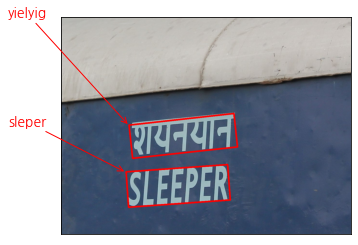

In [48]:
img_pil, cropped_img = detect_text(SAMPLE_IMG_PATH)
display(img_pil)

(-0.5, 420.5, 145.5, -0.5)

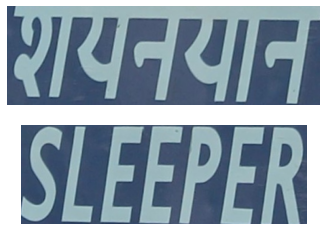

In [49]:
plt.subplot(2, 1, 1)
plt.imshow(cropped_img[0])
plt.axis('off')

plt.subplot(2, 1, 2)
plt.imshow(cropped_img[1])
plt.axis('off')

Result: 	 SLINKING9999999999999999


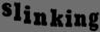

Result: 	 ALEPPO99999999999999999


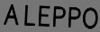

Result: 	 RWENDA999999999999999999


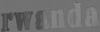

Result: 	 NATHANS99999999999999999


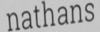

Result: 	 HALLO999999999999999999


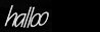

Result: 	 HURLS9999999999999999999


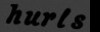

Result: 	 DOWNSIZE9999999999999999


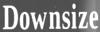

Result: 	 ROBOTIC99999999999999999


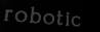

Result: 	 SLOPPY99999999999999999


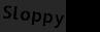

Result: 	 HERMITE99999999999999999


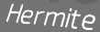

In [60]:
from IPython.display import display

test_set = MJDatasetSequence(TEST_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)

model, y_func = build_crnn_model()

model.load_weights(checkpoint_path)
input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)

def decode_predict_ctc(out, chars = TARGET_CHARACTERS, top_paths = 1):
    results = []
    beam_width = 5
    if beam_width < top_paths:
        beam_width = top_paths
    for i in range(top_paths):
        indexes = K.get_value(
            K.ctc_decode(
                out, input_length = np.ones(out.shape[0]) * out.shape[1],
                greedy =False , beam_width = beam_width, top_paths = top_paths
            )[0][i]
        )[0]
        text = ""
        for index in indexes:
            text += chars[index]
        results.append(text)
    return results

def check_inference(model, dataset, index = 5):
    for i in range(index):
        inputs, outputs = dataset[i]
        img = dataset[i][0]['input_image'][0:1,:,:,:]
        output = model_pred.predict(img)
        result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
        print("Result: \t", result)
        display(Image.fromarray(img[0].transpose(1,0,2).astype(np.uint8)))

check_inference(model, test_set, index=10)

In [61]:
def recognize_img(pil_img, input_img_size=(100,32)):
    img90 = cv2.rotate(pil_img, cv2.ROTATE_90_COUNTERCLOCKWISE)
    img_flip = cv2.flip(img90, 0)
    pil_img = cv2.resize(img_flip, (32, 100), interpolation = cv2.INTER_CUBIC)
    img = pil_img.reshape(1, 100, 32, 3)
    output = model_pred.predict(img)
    result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
    print("Result: \t", result)
    display(Image.fromarray(img[0].transpose(1,0,2).astype(np.uint8)))

Result: 	 HFEINT999999999999999999


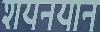

Result: 	 SLEEPER9999999999999999


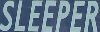

In [62]:
for _img in cropped_img:
    recognize_img(_img)